## Importing and prepping data

In [1]:
import pandas as pd

import diff_classifier.aws as aws
import diff_classifier.pca as pca

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

In [2]:
features = []
#featofvar = 'Type and Serum'

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}_XY{}.csv'.format(typ, slic, num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1")
                
                for extra in extras:
                    fstats[extra] = fstats.index
                fstats = fstats.drop(extras, axis=1)
                
                print('{} size: {}'.format(filename, fstats.shape))
                if 'PS' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                fstats['Well Number'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))

features_PS_1_XY1.csv
features_PS_1_XY1.csv size: (17215, 72)
features_PS_1_XY2.csv
features_PS_1_XY2.csv size: (36025, 72)
features_PS_1_XY3.csv
features_PS_1_XY3.csv size: (27995, 72)
features_PS_1_XY4.csv
features_PS_1_XY4.csv size: (31375, 72)
features_PS_1_XY5.csv
features_PS_1_XY5.csv size: (25037, 72)
features_PS_2_XY1.csv
features_PS_2_XY1.csv size: (13730, 72)
features_PS_2_XY2.csv
features_PS_2_XY2.csv size: (10992, 72)
features_PS_2_XY3.csv
features_PS_2_XY3.csv size: (18088, 72)
features_PS_2_XY4.csv
features_PS_2_XY4.csv size: (27814, 72)
features_PS_2_XY5.csv
features_PS_2_XY5.csv size: (21126, 72)
features_PEG_1_XY1.csv
features_PEG_1_XY1.csv size: (14422, 72)
features_PEG_1_XY2.csv
features_PEG_1_XY2.csv size: (10203, 72)
features_PEG_1_XY3.csv
features_PEG_1_XY3.csv size: (12272, 72)
features_PEG_1_XY4.csv
features_PEG_1_XY4.csv size: (15135, 72)
features_PEG_1_XY5.csv
features_PEG_1_XY5.csv size: (14631, 72)
features_PEG_2_XY1.csv
features_PEG_2_XY1.csv size: (12991, 

In [3]:
type_status = ['{} {}'.format(type_, status_) for type_, status_ in zip(fstats_tot['Type'].tolist(), fstats_tot['Cell Status'].tolist())]

In [4]:
fstats_tot['Type and Status'] = pd.Series(type_status, index=fstats_tot.index)

In [5]:
nonnum = ['Type', 'Type and Status', 'Cell Status', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index']

## Train-Test Split

In [6]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [7]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [8]:
f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [13]:
ncomp = 13
pcadataset = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.3492451643727596
1 component: 0.4648549231319693
2 component: 0.5350669756677643
3 component: 0.5811989880660681
4 component: 0.6196695775830273
5 component: 0.6550312560963285
6 component: 0.6829229230637628
7 component: 0.7081066279800352
8 component: 0.7316378722465002
9 component: 0.7525474905885716
10 component: 0.771701165312676
11 component: 0.7898814973932586
12 component: 0.8071445585589551


In [14]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean straightness,asymmetry3,Std asymmetry1,Percent Towards Cell,Std elongation,Std elongation,Membrane Xing,D_fit,Membrane Xing,Std Deff2,Std Deff2,Distance Towards Cell,kurtosis
1,Mean Deff1,asymmetry2,Std asymmetry2,frames,Std asymmetry2,alpha,Cell Distance,Std MSD_ratio,kurtosis,kurtosis,Mean Deff2,Std MSD_ratio,Membrane Xing
2,Mean efficiency,elongation,Mean asymmetry1,trappedness,Std asymmetry3,Std asymmetry3,Std alpha,Mean MSD_ratio,D_fit,Std MSD_ratio,Deff2,Mean MSD_ratio,Cell Distance
3,Mean D_fit,asymmetry1,efficiency,boundedness,alpha,Std asymmetry2,straightness,boundedness,Deff1,Std AR,Std boundedness,Std AR,Mean alpha
4,Std fractal_dim,Mean asymmetry1,asymmetry1,fractal_dim,Std asymmetry1,D_fit,efficiency,trappedness,Deff2,Mean Deff2,Std trappedness,Mean AR,Std straightness


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [15]:
pca_train = pcadataset

In [16]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

In [17]:
kmostat = pca.kmo(pca_train.scaled)

0.947750213197


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [18]:
import numpy as np
featofvar = 'Type and Status'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='PEG False'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='COOH False'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='PEG True'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='COOH True'].values[:, -ncomp:], axis=0)

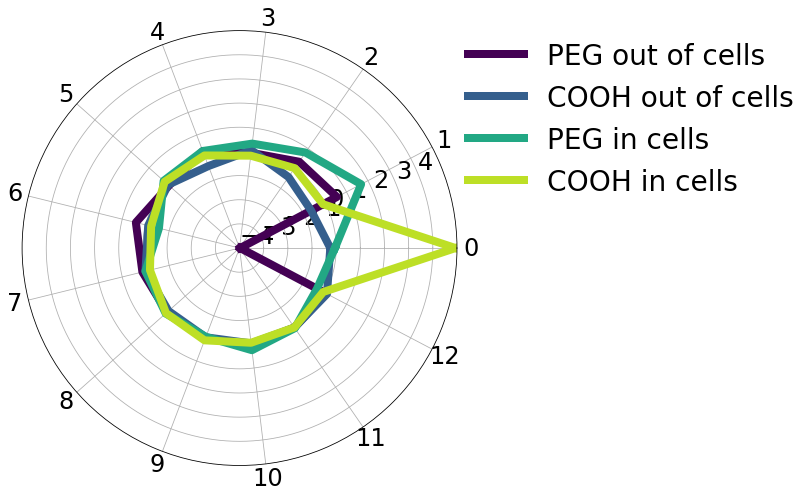

In [19]:
labels2 = ['PEG out of cells', 'COOH out of cells', 'PEG in cells', 'COOH in cells']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-4, 4, 9), dpi=1200, labelsize=24,
             filename='pics/Fig5/cells_pcaavg.png')

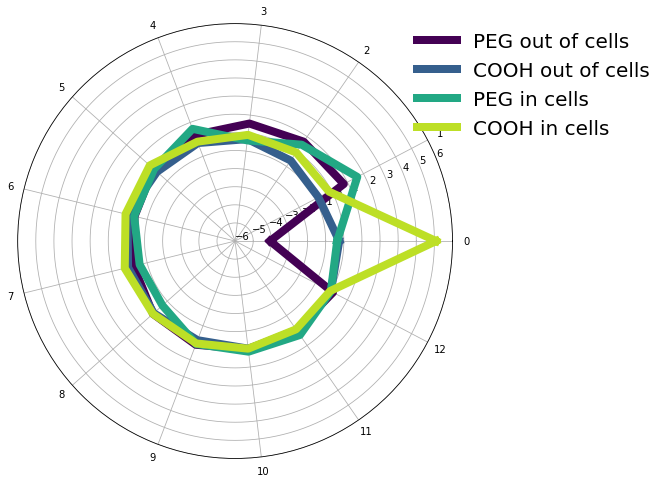

In [14]:
labels2 = ['PEG out of cells', 'COOH out of cells', 'PEG in cells', 'COOH in cells']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-6, 6, 13))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

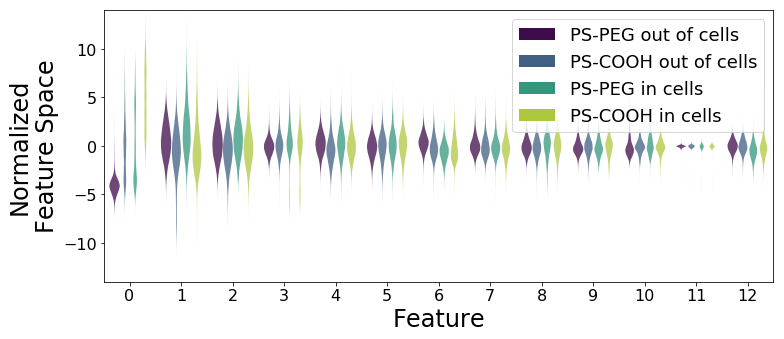

In [22]:
labels3 = ['PS-PEG out of cells', 'PS-COOH out of cells', 'PS-PEG in cells', 'PS-COOH in cells']
labels = ['PEG False', 'COOH False', 'PEG True', 'COOH True']
feats = feature_violin(pcadataset.final, label='Type and Status', lvals=labels, labels=labels3, fsubset=ncomp, yrange=[-14, 14],
                       legendfontsize=18, labelsize=24, fname='./pics/Fig5/cells_pcadist.png')

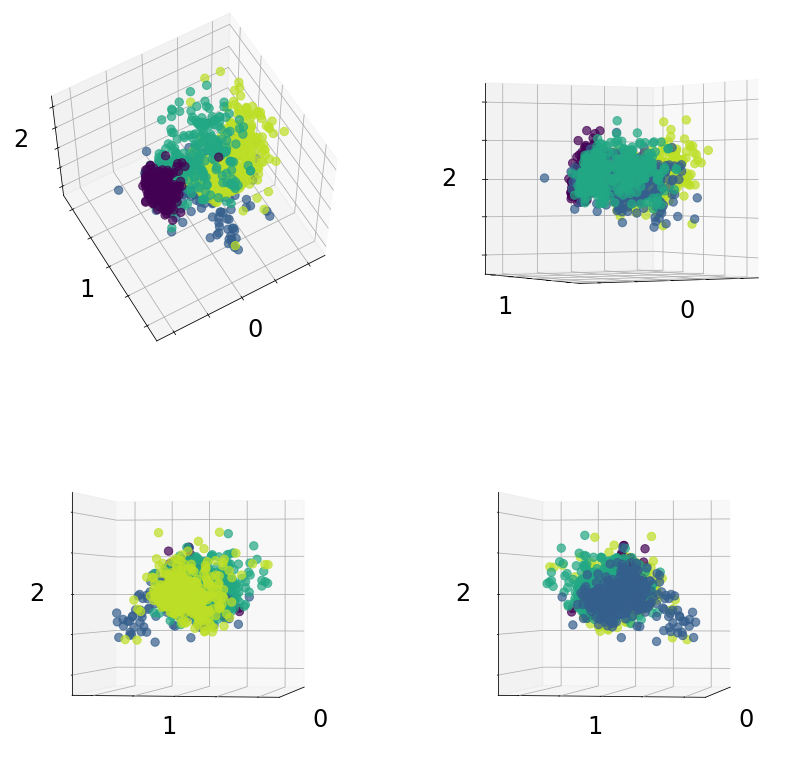

In [24]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              filename='./pics/Fig5/cells_3feats.png')

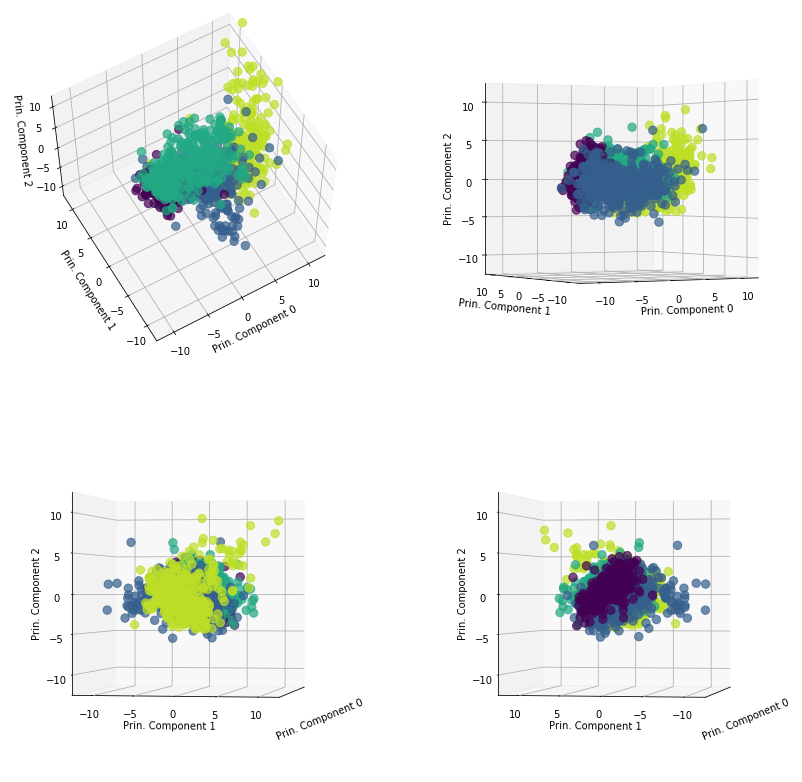

In [17]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

## Neural Network

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [26]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.58221066
Validation score: 0.774874
Iteration 2, loss = 0.53131635
Validation score: 0.785006
Iteration 3, loss = 0.50939117
Validation score: 0.790654
Iteration 4, loss = 0.49191704
Validation score: 0.796357
Iteration 5, loss = 0.47586971
Validation score: 0.805714
Iteration 6, loss = 0.46349006
Validation score: 0.815625
Iteration 7, loss = 0.45220007
Validation score: 0.819445
Iteration 8, loss = 0.44166687
Validation score: 0.825536
Iteration 9, loss = 0.43139695
Validation score: 0.828304
Iteration 10, loss = 0.42352912
Validation score: 0.830574
Iteration 11, loss = 0.41573906
Validation score: 0.829744
Iteration 12, loss = 0.40769813
Validation score: 0.835668
Iteration 13, loss = 0.40174607
Validation score: 0.840374
Iteration 14, loss = 0.39619073
Validation score: 0.845081
Iteration 15, loss = 0.39084594
Validation score: 0.838990
Iteration 16, loss = 0.38543869
Validation score: 0.852832
Iteration 17, loss = 0.38266438
Validation score: 0.840762
Iterat

In [29]:
X_train = pca_train.final[np.abs(pca_train.final['Cell Distance']) > 10].values[:, -ncomp:]
X_test = pca_test.final[np.abs(pca_test.final['Cell Distance']) > 10].values[:, -ncomp:]
y_train = pca_train.final[np.abs(pca_train.final['Cell Distance']) > 10][featofvar].values
y_test = pca_test.final[np.abs(pca_test.final['Cell Distance']) > 10][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.54011819
Validation score: 0.795937
Iteration 2, loss = 0.48866162
Validation score: 0.806155
Iteration 3, loss = 0.46665873
Validation score: 0.807177
Iteration 4, loss = 0.44906070
Validation score: 0.821362
Iteration 5, loss = 0.43255290
Validation score: 0.828875
Iteration 6, loss = 0.41820199
Validation score: 0.827132
Iteration 7, loss = 0.40571753
Validation score: 0.839454
Iteration 8, loss = 0.39253345
Validation score: 0.843181
Iteration 9, loss = 0.38152913
Validation score: 0.853159
Iteration 10, loss = 0.37153518
Validation score: 0.851295
Iteration 11, loss = 0.36286778
Validation score: 0.857126
Iteration 12, loss = 0.35380794
Validation score: 0.849552
Iteration 13, loss = 0.34649879
Validation score: 0.869568
Iteration 14, loss = 0.33866872
Validation score: 0.871371
Iteration 15, loss = 0.33300208
Validation score: 0.865300
Iteration 16, loss = 0.32721932
Validation score: 0.876420
Iteration 17, loss = 0.31974381
Validation score: 0.873415
Iterat

In [30]:
X_train = pca_train.final[np.abs(pca_train.final['Cell Distance']) > 20].values[:, -ncomp:]
X_test = pca_test.final[np.abs(pca_test.final['Cell Distance']) > 20].values[:, -ncomp:]
y_train = pca_train.final[np.abs(pca_train.final['Cell Distance']) > 20][featofvar].values
y_test = pca_test.final[np.abs(pca_test.final['Cell Distance']) > 20][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.50885080
Validation score: 0.817488
Iteration 2, loss = 0.45609668
Validation score: 0.822643
Iteration 3, loss = 0.43566119
Validation score: 0.828972
Iteration 4, loss = 0.41861047
Validation score: 0.835954
Iteration 5, loss = 0.40363733
Validation score: 0.843197
Iteration 6, loss = 0.38988025
Validation score: 0.847504
Iteration 7, loss = 0.37745419
Validation score: 0.852007
Iteration 8, loss = 0.36550763
Validation score: 0.860228
Iteration 9, loss = 0.35325980
Validation score: 0.861599
Iteration 10, loss = 0.34322493
Validation score: 0.868320
Iteration 11, loss = 0.33390698
Validation score: 0.867210
Iteration 12, loss = 0.32479184
Validation score: 0.878630
Iteration 13, loss = 0.31678059
Validation score: 0.877781
Iteration 14, loss = 0.30822126
Validation score: 0.886199
Iteration 15, loss = 0.30127218
Validation score: 0.878630
Iteration 16, loss = 0.29511228
Validation score: 0.882480
Iteration 17, loss = 0.28994734
Validation score: 0.888287
Iterat

In [31]:
X_train = pca_train.final[(pca_train.final['Type']=='PEG') & (np.abs(pca_train.final['Cell Distance']) > 20)].values[:, -ncomp:]
X_test = pca_test.final[(pca_test.final['Type']=='PEG') & (np.abs(pca_test.final['Cell Distance']) > 20)].values[:, -ncomp:]
y_train = pca_train.final[(pca_train.final['Type']=='PEG') & (np.abs(pca_train.final['Cell Distance']) > 20)][featofvar].values
y_test = pca_test.final[(pca_test.final['Type']=='PEG') & (np.abs(pca_test.final['Cell Distance']) > 20)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.15041988
Validation score: 0.948580
Iteration 2, loss = 0.13041317
Validation score: 0.948244
Iteration 3, loss = 0.12567082
Validation score: 0.951101
Iteration 4, loss = 0.12274463
Validation score: 0.950765
Iteration 5, loss = 0.12055412
Validation score: 0.952277
Iteration 6, loss = 0.11858639
Validation score: 0.952949
Iteration 7, loss = 0.11754363
Validation score: 0.953789
Iteration 8, loss = 0.11606620
Validation score: 0.954966
Iteration 9, loss = 0.11506673
Validation score: 0.954629
Iteration 10, loss = 0.11375506
Validation score: 0.955470
Iteration 11, loss = 0.11308347
Validation score: 0.954629
Iteration 12, loss = 0.11200332
Validation score: 0.957486
Iteration 13, loss = 0.11130348
Validation score: 0.955302
Iteration 14, loss = 0.11033965
Validation score: 0.956310
Iteration 15, loss = 0.10927402
Validation score: 0.955638
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iterat

In [32]:
X_train = pca_train.final[(pca_train.final['Type']=='COOH') & (np.abs(pca_train.final['Cell Distance']) > 20)].values[:, -ncomp:]
X_test = pca_test.final[(pca_test.final['Type']=='COOH') & (np.abs(pca_test.final['Cell Distance']) > 20)].values[:, -ncomp:]
y_train = pca_train.final[(pca_train.final['Type']=='COOH') & (np.abs(pca_train.final['Cell Distance']) > 20)][featofvar].values
y_test = pca_test.final[(pca_test.final['Type']=='COOH') & (np.abs(pca_test.final['Cell Distance']) > 20)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.22172229
Validation score: 0.929059
Iteration 2, loss = 0.18640561
Validation score: 0.935140
Iteration 3, loss = 0.17740374
Validation score: 0.937273
Iteration 4, loss = 0.17093663
Validation score: 0.940260
Iteration 5, loss = 0.16537075
Validation score: 0.941434
Iteration 6, loss = 0.15956259
Validation score: 0.943887
Iteration 7, loss = 0.15438499
Validation score: 0.943034
Iteration 8, loss = 0.14970620
Validation score: 0.946021
Iteration 9, loss = 0.14505909
Validation score: 0.949008
Iteration 10, loss = 0.14039309
Validation score: 0.952208
Iteration 11, loss = 0.13617752
Validation score: 0.952635
Iteration 12, loss = 0.13200704
Validation score: 0.953168
Iteration 13, loss = 0.12827321
Validation score: 0.956262
Iteration 14, loss = 0.12426526
Validation score: 0.956475
Iteration 15, loss = 0.12002278
Validation score: 0.957862
Iteration 16, loss = 0.11699024
Validation score: 0.959889
Iteration 17, loss = 0.11374036
Validation score: 0.961703
Iterat

In [33]:
fstats_tot.columns

Index(['AR', 'Cell Distance', 'Cell Status', 'D_fit', 'Deff1', 'Deff2',
       'Distance Towards Cell', 'MSD_ratio', 'Mean AR', 'Mean D_fit',
       'Mean Deff1', 'Mean Deff2', 'Mean MSD_ratio', 'Mean Mean_Intensity',
       'Mean Quality', 'Mean SN_Ratio', 'Mean X', 'Mean Y', 'Mean alpha',
       'Mean asymmetry1', 'Mean asymmetry2', 'Mean asymmetry3',
       'Mean boundedness', 'Mean efficiency', 'Mean elongation',
       'Mean fractal_dim', 'Mean frames', 'Mean kurtosis', 'Mean straightness',
       'Mean trappedness', 'Mean_Intensity', 'Membrane Xing',
       'Percent Towards Cell', 'Quality', 'SN_Ratio', 'Std AR', 'Std D_fit',
       'Std Deff1', 'Std Deff2', 'Std MSD_ratio', 'Std Mean_Intensity',
       'Std Quality', 'Std SN_Ratio', 'Std X', 'Std Y', 'Std alpha',
       'Std asymmetry1', 'Std asymmetry2', 'Std asymmetry3', 'Std boundedness',
       'Std efficiency', 'Std elongation', 'Std fractal_dim', 'Std frames',
       'Std kurtosis', 'Std straightness', 'Std trappedness', '

In [ ]:
test = pcadataset.final[pcadataset.final['Type']=='PEG'].values[:, -ncomp:]
y = pcadataset.final[pcadataset.final['Type']=='PEG']['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [15]:
test = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 10].values[:, -ncomp:]
y = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 10]['Type and Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.47792389
Validation score: 0.831188
Iteration 2, loss = 0.43674026
Validation score: 0.836228
Iteration 3, loss = 0.42360136
Validation score: 0.839571
Iteration 4, loss = 0.41486217
Validation score: 0.844411
Iteration 5, loss = 0.40788932
Validation score: 0.846956
Iteration 6, loss = 0.40172009
Validation score: 0.849601
Iteration 7, loss = 0.39623559
Validation score: 0.852944
Iteration 8, loss = 0.39077865
Validation score: 0.855938
Iteration 9, loss = 0.38583722
Validation score: 0.855888
Iteration 10, loss = 0.38152340
Validation score: 0.859980
Iteration 11, loss = 0.37659601
Validation score: 0.861277
Iteration 12, loss = 0.37240868
Validation score: 0.864222
Iteration 13, loss = 0.36819658
Validation score: 0.862475
Iteration 14, loss = 0.36443399
Validation score: 0.866717
Iteration 15, loss = 0.36065882
Validation score: 0.868014
Iteration 16, loss = 0.35736887
Validation score: 0.864721
Iteration 17, loss = 0.35391436
Validation score: 0.871507
Iterat

Text(0,0.5,'Validation Scores')

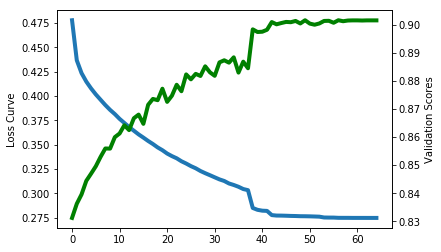

In [17]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.245, 0.265])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.90, 0.92])
ax2.set_ylabel('Validation Scores')

In [18]:
test = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 20].values[:, -ncomp:]
y = pcadataset.final[np.abs(pcadataset.final['Cell Distance']) > 20]['Type and Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(800, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.43952616
Validation score: 0.853780
Iteration 2, loss = 0.39406742
Validation score: 0.858055
Iteration 3, loss = 0.38073923
Validation score: 0.860274
Iteration 4, loss = 0.37229033
Validation score: 0.862547
Iteration 5, loss = 0.36559275
Validation score: 0.864332
Iteration 6, loss = 0.36053388
Validation score: 0.867688
Iteration 7, loss = 0.35481894
Validation score: 0.870556
Iteration 8, loss = 0.35006475
Validation score: 0.872937
Iteration 9, loss = 0.34566216
Validation score: 0.873316
Iteration 10, loss = 0.34153690
Validation score: 0.876941
Iteration 11, loss = 0.33726580
Validation score: 0.875480
Iteration 12, loss = 0.33375316
Validation score: 0.878240
Iteration 13, loss = 0.33024685
Validation score: 0.878727
Iteration 14, loss = 0.32658532
Validation score: 0.879160
Iteration 15, loss = 0.32314525
Validation score: 0.881108
Iteration 16, loss = 0.32021167
Validation score: 0.880297
Iteration 17, loss = 0.31701002
Validation score: 0.882894
Iterat

Text(0,0.5,'Validation Scores')

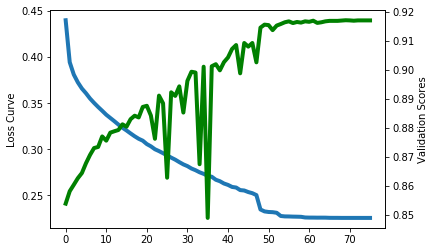

In [19]:
fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
#ax1.set_ylim([0.245, 0.265])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
#ax2.set_ylim([0.90, 0.92])
ax2.set_ylabel('Validation Scores')

## Alternate binning

In [8]:
bins = list(range(0, 2048+1, 256))
pcadataset.final['binx'] = pd.cut(pcadataset.final.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
pcadataset.final['biny'] = pd.cut(pcadataset.final.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
pcadataset.final['bins'] = 8*pcadataset.final['binx'] + pcadataset.final['biny']
pcadataset.final = pcadataset.final[np.isfinite(pcadataset.final.bins)]
pcadataset.final.bins = pcadataset.final.bins.astype(int)

cols = pcadataset.final.columns.tolist()
cols = cols[-3:] + cols[:-3]
pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [12]:
featofvar = 'Type and Status'
#ncomp = 16

X_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)].values[:, -ncomp:]
X_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)][featofvar].values
y_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.44763374
Validation score: 0.848350
Iteration 2, loss = 0.40462877
Validation score: 0.851295
Iteration 3, loss = 0.38761905
Validation score: 0.863557
Iteration 4, loss = 0.37325139
Validation score: 0.870890
Iteration 5, loss = 0.36091817
Validation score: 0.877502
Iteration 6, loss = 0.34992182
Validation score: 0.879726
Iteration 7, loss = 0.34113696
Validation score: 0.881108
Iteration 8, loss = 0.33256707
Validation score: 0.887239
Iteration 9, loss = 0.32517786
Validation score: 0.882311
Iteration 10, loss = 0.31930921
Validation score: 0.886398
Iteration 11, loss = 0.31285392
Validation score: 0.891807
Iteration 12, loss = 0.30763810
Validation score: 0.891387
Iteration 13, loss = 0.30268436
Validation score: 0.886638
Iteration 14, loss = 0.29857607
Validation score: 0.893671
Iteration 15, loss = 0.29401675
Validation score: 0.899862
Iteration 16, loss = 0.28988823
Validation score: 0.900463
Iteration 17, loss = 0.28603568
Validation score: 0.903348
Iterat

In [17]:
featofvar = 'Type and Status'
#ncomp = 16

X_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 20)].values[:, -ncomp:]
X_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 20)].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 20)][featofvar].values
y_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 20)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.40516308
Validation score: 0.864339
Iteration 2, loss = 0.36043342
Validation score: 0.871452
Iteration 3, loss = 0.34425990
Validation score: 0.878369
Iteration 4, loss = 0.33211135
Validation score: 0.884502
Iteration 5, loss = 0.32097209
Validation score: 0.886656
Iteration 6, loss = 0.31077544
Validation score: 0.890701
Iteration 7, loss = 0.30187500
Validation score: 0.892137
Iteration 8, loss = 0.29410202
Validation score: 0.894160
Iteration 9, loss = 0.28606039
Validation score: 0.898532
Iteration 10, loss = 0.27920964
Validation score: 0.900294
Iteration 11, loss = 0.27265933
Validation score: 0.892268
Iteration 12, loss = 0.26714619
Validation score: 0.908581
Iteration 13, loss = 0.26247101
Validation score: 0.907993
Iteration 14, loss = 0.25655899
Validation score: 0.911191
Iteration 15, loss = 0.25157369
Validation score: 0.909690
Iteration 16, loss = 0.24737450
Validation score: 0.918303
Iteration 17, loss = 0.24343603
Validation score: 0.910995
Iterat

In [13]:
featofvar = 'Type and Status'
#ncomp = 16

X_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 0)].values[:, -ncomp:]
X_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 0)].values[:, -ncomp:]
y_train = pcadataset.final[(pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 0)][featofvar].values
y_test = pcadataset.final[(~pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 0)][featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.49595349
Validation score: 0.821438
Iteration 2, loss = 0.45705165
Validation score: 0.829079
Iteration 3, loss = 0.44037976
Validation score: 0.836720
Iteration 4, loss = 0.42693186
Validation score: 0.843087
Iteration 5, loss = 0.41576691
Validation score: 0.844527
Iteration 6, loss = 0.40656641
Validation score: 0.849898
Iteration 7, loss = 0.39796132
Validation score: 0.852334
Iteration 8, loss = 0.39061368
Validation score: 0.855711
Iteration 9, loss = 0.38356397
Validation score: 0.849012
Iteration 10, loss = 0.37791087
Validation score: 0.855268
Iteration 11, loss = 0.37220254
Validation score: 0.862411
Iteration 12, loss = 0.36766848
Validation score: 0.865290
Iteration 13, loss = 0.36199992
Validation score: 0.866397
Iteration 14, loss = 0.35814296
Validation score: 0.867062
Iteration 15, loss = 0.35470994
Validation score: 0.871325
Iteration 16, loss = 0.35096902
Validation score: 0.862079
Iteration 17, loss = 0.34751156
Validation score: 0.871713
Iterat

In [15]:
test = pcadataset.final[(pcadataset.final['Type']=='PEG') & (pcadataset.final.bins.isin(checkerboard(8)))].values[:, -ncomp:]
y = pcadataset.final[(pcadataset.final['Type']=='PEG') & (pcadataset.final.bins.isin(checkerboard(8)))]['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.28031811
Validation score: 0.906533
Iteration 2, loss = 0.26975325
Validation score: 0.907538
Iteration 3, loss = 0.26745484
Validation score: 0.906784
Iteration 4, loss = 0.26559948
Validation score: 0.908291
Iteration 5, loss = 0.26443952
Validation score: 0.907286
Iteration 6, loss = 0.26316626
Validation score: 0.908291
Iteration 7, loss = 0.26195703
Validation score: 0.907538
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 8, loss = 0.26000711
Validation score: 0.907789
Iteration 9, loss = 0.25946770
Validation score: 0.907286
Iteration 10, loss = 0.25930591
Validation score: 0.907789
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.000200
Iteration 11, loss = 0.25882276
Validation score: 0.908040
Iteration 12, loss = 0.25872686
Validation score: 0.908291
Iteration 13, loss = 0.25866540
Validation score: 0.908040
Valida

In [16]:
test = pcadataset.final[(pcadataset.final['Type']=='COOH') & (pcadataset.final.bins.isin(checkerboard(8)))].values[:, -ncomp:]
y = pcadataset.final[(pcadataset.final['Type']=='COOH') & (pcadataset.final.bins.isin(checkerboard(8)))]['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.34101991
Validation score: 0.858830
Iteration 2, loss = 0.31518114
Validation score: 0.866706
Iteration 3, loss = 0.30727631
Validation score: 0.868164
Iteration 4, loss = 0.30150880
Validation score: 0.869914
Iteration 5, loss = 0.29589781
Validation score: 0.872685
Iteration 6, loss = 0.29060268
Validation score: 0.873268
Iteration 7, loss = 0.28489977
Validation score: 0.878810
Iteration 8, loss = 0.27967510
Validation score: 0.878227
Iteration 9, loss = 0.27449901
Validation score: 0.884643
Iteration 10, loss = 0.26947229
Validation score: 0.887852
Iteration 11, loss = 0.26420398
Validation score: 0.883768
Iteration 12, loss = 0.26018801
Validation score: 0.891206
Iteration 13, loss = 0.25499550
Validation score: 0.896019
Iteration 14, loss = 0.25120542
Validation score: 0.895873
Iteration 15, loss = 0.24670983
Validation score: 0.892956
Iteration 16, loss = 0.24336912
Validation score: 0.892373
Validation score did not improve more than tol=0.000010 for two c

In [18]:
test = pcadataset.final[(pcadataset.final['Type']=='PEG') & (pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)].values[:, -ncomp:]
y = pcadataset.final[(pcadataset.final['Type']=='PEG') & (pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)]['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.23015116
Validation score: 0.928136
Iteration 2, loss = 0.21978853
Validation score: 0.928666
Iteration 3, loss = 0.21698464
Validation score: 0.930257
Iteration 4, loss = 0.21536280
Validation score: 0.929727
Iteration 5, loss = 0.21410510
Validation score: 0.930522
Iteration 6, loss = 0.21240430
Validation score: 0.931318
Iteration 7, loss = 0.21122109
Validation score: 0.931848
Iteration 8, loss = 0.20989951
Validation score: 0.931318
Iteration 9, loss = 0.20886233
Validation score: 0.932644
Iteration 10, loss = 0.20768106
Validation score: 0.932644
Iteration 11, loss = 0.20653083
Validation score: 0.932379
Iteration 12, loss = 0.20596700
Validation score: 0.931583
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 13, loss = 0.20362359
Validation score: 0.931848
Iteration 14, loss = 0.20313970
Validation score: 0.930788
Iteration 15, loss = 0.20308033
Validation score: 0.932113
Valida

In [19]:
test = pcadataset.final[(pcadataset.final['Type']=='COOH') & (pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)].values[:, -ncomp:]
y = pcadataset.final[(pcadataset.final['Type']=='COOH') & (pcadataset.final.bins.isin(checkerboard(8))) & (np.abs(pcadataset.final['Cell Distance']) > 10)]['Cell Status'].values
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.28079216
Validation score: 0.887798
Iteration 2, loss = 0.24980895
Validation score: 0.894881
Iteration 3, loss = 0.24166859
Validation score: 0.894720
Iteration 4, loss = 0.23530430
Validation score: 0.901320
Iteration 5, loss = 0.22978401
Validation score: 0.902447
Iteration 6, loss = 0.22474371
Validation score: 0.908081
Iteration 7, loss = 0.21978811
Validation score: 0.914842
Iteration 8, loss = 0.21505110
Validation score: 0.913232
Iteration 9, loss = 0.20975867
Validation score: 0.918223
Iteration 10, loss = 0.20413269
Validation score: 0.920316
Iteration 11, loss = 0.20062323
Validation score: 0.919350
Iteration 12, loss = 0.19527124
Validation score: 0.924179
Iteration 13, loss = 0.19061084
Validation score: 0.925467
Iteration 14, loss = 0.18666800
Validation score: 0.903896
Iteration 15, loss = 0.18344056
Validation score: 0.929813
Iteration 16, loss = 0.17902537
Validation score: 0.926916
Iteration 17, loss = 0.17572319
Validation score: 0.932228
Iterat

In [ ]:
for run in range(1):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=100, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
def build_modelR(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'NNsolver': 'adam', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                }

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'MLP':
        clf = MLPRegressor(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'],
                            beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'],
                            epsilon=kwargs['epsilon'])
    
        clf.fit(X, y)
        return clf, X, y

In [ ]:
labels2 = [0.4, 0.6, 0.8, 1.0, 1.2]

trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Bulk Agarose Int', labels2, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y2, MLPmod.predict(X2), alpha=0.002)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y, MLPmod.predict(X), alpha=0.006)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
labelshort = [0.4, 0.6, 0.8, 1.0]
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose Int'].isin(labelshort)]
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcasub, 'Bulk Agarose Int', labelshort, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
combos = [['0_8', '1_0']]
vids = 5

counter = 0
for combo in combos:
    for num in range(1, vids+1):

        filename = 'features_100x_{}_{}_gel_interface_vid_{}.csv'.format(combo[0], combo[1], num)
        aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
        fstats_new1 = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        #fstats['Percent Agarose'] = pd.Series(fstats.shape[0]*[str(visc[key])], index=fstats.index)
        #print(fstats_new.shape[0])
        fstats_new1['Video Number'] = pd.Series(fstats_new1.shape[0]*[num], index=fstats_new1.index)
        fstats_new1['Interface'] = pd.Series(fstats_new1.shape[0]*['{}/{}'.format(combo[0], combo[1])], index=fstats_new1.index)
        #print(num)
        print(filename)
        counter = counter + 1
        if counter == 1:
            fstats_tot1 = fstats_new1
        else:
            fstats_tot1 = fstats_tot1.append(fstats_new1, ignore_index=True)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '1_2'], legendloc=2)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '0_8'], legendloc=2)

In [ ]:
from matplotlib.pyplot import cm
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=3
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_6', '0_8'])

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=4
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_8', '1_0'])

In [ ]:
def feature_plot_2D(dataset, label, features=[0, 1], lvals=['PEG', 'PS'],
                    randsel=True, randcount=200, **kwargs):

    defaults = {'figsize': (8, 8), 'dotsize': 70, 'alpha': 0.7, 'xlim': None,
                'ylim': None, 'legendfontsize': 12, 'labelfontsize': 20,
                'fname': None, 'legendloc': 2}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    tgroups = {}
    xy = {}
    counter = 0
    labels = dataset[label].unique()
    for lval in lvals:
        tgroups[counter] = dataset[dataset[label] == lval]
        counter = counter + 1

    N = len(tgroups)
    color = iter(cm.viridis(np.linspace(0, 0.9, N)))

    fig = plt.figure(figsize=kwargs['figsize'])
    ax1 = fig.add_subplot(111)
    counter = 0
    for key in tgroups:
        c = next(color)
        xy = []
        if randsel:
            to_plot = random.sample(range(0, len(tgroups[key][0].tolist())),
                                    randcount)
            for key2 in features:
                xy.append(list(tgroups[key][key2].tolist()[i] for i in to_plot))
        else:
            for key2 in features:
                xy.append(tgroups[key][key2])
        ax1 = plt.scatter(xy[0], xy[1], c=c, s=kwargs['dotsize'],
                          alpha=kwargs['alpha'], label=labels[counter])
        counter = counter + 1

    if kwargs['xlim'] is not None:
        plt.xlim(kwargs['xlim'])
    if kwargs['ylim'] is not None:
        plt.ylim(kwargs['ylim'])

    plt.legend(fontsize=kwargs['legendfontsize'], frameon=False,
               borderaxespad=0., loc=2,
               bbox_to_anchor=(1, 1))
    plt.xlabel('Prin. Component {}'.format(features[0]),
               fontsize=kwargs['labelfontsize'])
    plt.ylabel('Prin. Component {}'.format(features[1]),
               fontsize=kwargs['labelfontsize'])

    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'])

    return xy

In [ ]:
prefix = 'PEG_2_XY1'
ffilename = 'features_{}.csv'.format(prefix)
mfilename = 'msd_{}.csv'.format(prefix)
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1',
          'Unnamed: 0.1.1.1.1.1']

fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")     
for extra in extras:
    fstats[extra] = fstats.index
fstats = fstats.drop(extras, axis=1)

msds = pd.read_csv(mfilename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
for extra in extras:
    msds[extra] = msds.index
msds = msds.drop(extras, axis=1)

In [ ]:
fstats.head()

In [ ]:
msds.head()

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=200))]

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=1000))]
t_min, t_max = -750, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

In [ ]:
sample1 = msds[msds['Track_ID'].isin(random.sample(msds[(msds['Cell Status']==False)]['Track_ID'].unique().tolist(), k=500))]
sample2 = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
fig, ax = plt.subplots(figsize=(10, 10))

t_min, t_max = 0, 1
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for i in sample2.Track_ID.unique():
    ax.plot(sample2[sample2.Track_ID==i].Frame/100.02, sample2[sample2.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0.9), alpha=0.25)

for i in sample1.Track_ID.unique():
    ax.plot(sample1[sample1.Track_ID==i].Frame/100.02, sample1[sample1.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0), alpha=0.25)

plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

In [ ]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
t_min, t_max = -700, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)